In [36]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', None)

In [37]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px, 
    pl.NameParentTeam,
    v.URL
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
LEFT JOIN 
    mlb_stats.dbo.pbp_play_event_video AS v
    ON v.GamePk = pe.GamePk 
    AND v.PlayId = pe.PlayId
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'SL' 
    AND YEAR(g.GameDate) = 2024
    AND pl.NameParentTeam = 'Oakland Athletics'
	AND g.GameType = 'R'
    AND v.Source = 'BROADCAST'
"""

OAK_sliders=pd.read_sql(query,cnxn) 

C:\Users\jreydel\AppData\Local\Temp\ipykernel_11572\1882911455.py:64: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [58]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complsl = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'SL' AND SplitType = 'All' AND TP > 75 AND CommandPlus IS NOT NULL
"""


OAK_slider_command=pd.read_sql(query_complsl,cnxn) 

print(OAK_slider_command)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_11572\62913008.py:64: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



                           Name  PlayerID Throws Level  LeagueLevel  Season  \
0             Verlander, Justin    434378      R   MLB            1    2024   
1               Morton, Charlie    450203      R   MLB            1    2024   
2                 Scherzer, Max    453286      R   MLB            1    2024   
3                 Cueto, Johnny    456501      R   AAA            2    2024   
4                Wilson, Justin    458677      L   MLB            1    2024   
5              Carrasco, Carlos    471911      R   MLB            1    2024   
6                 Peralta, Wily    503449      R   AAA            2    2024   
7                   Darvish, Yu    506433      R   MLB            1    2024   
8                Cruz, Fernando    518585      R   MLB            1    2024   
9                 Pressly, Ryan    519151      R   MLB            1    2024   
10                  Sale, Chris    519242      L   MLB            1    2024   
11                  Smith, Will    519293      L   M

In [59]:
def calculate_vaa(row):
    yf = 17/12  # Home plate distance in feet, converted to inches
    ay = row['ay']  # Acceleration in y-dimension for the current pitch
    vy0 = row['vy0']  # Velocity in y-dimension at y=50 feet for the current pitch
    vz0 = row['vz0']  # Velocity in z-dimension at y=50 feet for the current pitch
    az = row['az']  # Acceleration in z-dimension for the current pitch

    vy_f = -sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    return vaa_deg
OAK_sliders['VAA'] = OAK_sliders.apply(calculate_vaa, axis=1)

In [60]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

In [61]:
OAK_sliders['VRA'] = OAK_sliders.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
OAK_sliders['HRA'] = OAK_sliders.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)

In [62]:
pitch_count = OAK_sliders['NamePlayer'].value_counts()

OAK_sl_filtered = OAK_sliders[OAK_sliders['NamePlayer'].isin(pitch_count.index[pitch_count >= 150])]

In [63]:
grouped_sl = OAK_sl_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_sl['VRA_percentile'] = 1 - grouped_sl['VRA'].rank(pct=True)
grouped_sl['HRA_percentile'] = 1 - grouped_sl['HRA'].rank(pct=True)
grouped_sl['release_pos_z_percentile'] = 1 - grouped_sl['ReleaseZ'].rank(pct=True)
grouped_sl['release_pos_x_percentile'] = 1 - grouped_sl['ReleaseX'].rank(pct=True)

grouped_sl['kirby_index'] = (
    grouped_sl['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_sl['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_sl['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_sl['release_pos_x_percentile'] * weights['ReleaseX']
)

OAK_ranked_pitchers_weighted_sl = grouped_sl.sort_values('kirby_index', ascending=False)

In [64]:
print(OAK_ranked_pitchers_weighted_sl)

           NamePlayer  PitcherId       VRA       HRA  ReleaseX  ReleaseZ  \
16         Joey Estes     683155  0.882522  0.718880  0.129545  0.092734   
26     Ross Stripling     548389  0.980691  0.592861  0.142107  0.082325   
25       Osvaldo Bido     674370  0.846937  0.888882  0.144333  0.089751   
24        Mitch Myers     688490  0.910683  0.730345  0.195653  0.104155   
2           Alex Wood     622072  0.800524  1.012007  0.095036  0.098618   
0        Aaron Brooks     605156  0.857895  0.895637  0.157542  0.094827   
21       Mason Miller     695243  0.956870  0.962914  0.139084  0.093168   
10     Gunnar Hoglund     680684  1.000765  0.848771  0.199606  0.092384   
18      Luis Carrasco     682918  0.826665  0.891628  0.204596  0.118397   
13       Jack Cushing     681007  0.991422  0.800705  0.247515  0.097489   
14    Jack O'Loughlin     672552  0.968713  0.979597  0.180380  0.090395   
17        Kyle Muller     666205  1.156022  0.612775  0.147317  0.105060   
12          

In [65]:
filtered_slider_command = OAK_slider_command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'CommandPlus', 'InZone']]
OAK_full_slider_command = pd.merge(OAK_ranked_pitchers_weighted_sl, filtered_slider_command, how='left', left_on='PitcherId', right_on='PlayerID')
OAK_full_slider_command_unique = OAK_full_slider_command.drop_duplicates(subset=['NamePlayer'])

from IPython.display import display

display(OAK_full_slider_command_unique)

,NamePlayer,PitcherId,VRA,HRA,ReleaseX,ReleaseZ,VRA_percentile,HRA_percentile,release_pos_z_percentile,release_pos_x_percentile,kirby_index,PlayerID,StrikeRate,CalledStrikeRate,CommandPlus,InZone
0,Joey Estes,683155,0.882522,0.718880,0.129545,0.092734,0.828571,0.885714,0.828571,0.914286,0.856000,683155,0.729167,0.111111,50,0.548611
1,Ross Stripling,548389,0.980691,0.592861,0.142107,0.082325,0.714286,0.971429,0.971429,0.771429,0.835429,548389,0.664671,0.077844,65,0.443114
2,Osvaldo Bido,674370,0.846937,0.888882,0.144333,0.089751,0.885714,0.514286,0.942857,0.742857,0.775143,674370,0.693227,0.119522,55,0.521912
3,Mitch Myers,688490,0.910683,0.730345,0.195653,0.104155,0.800000,0.857143,0.542857,0.428571,0.719714,688490,0.706215,0.090395,60,0.536723
4,Alex Wood,622072,0.800524,1.012007,0.095036,0.098618,0.971429,0.257143,0.600000,0.971429,0.715429,622072,0.510549,0.232068,50,0.362869
5,Aaron Brooks,605156,0.857895,0.895637,0.157542,0.094827,0.857143,0.457143,0.742857,0.657143,0.701714,605156,0.666667,0.172691,45,0.421687
7,Mason Miller,695243,0.956870,0.962914,0.139084,0.093168,0.771429,0.342857,0.800000,0.857143,0.672571,695243,0.668122,0.222707,50,0.419214
8,Gunnar Hoglund,680684,1.000765,0.848771,0.199606,0.092384,0.657143,0.657143,0.885714,0.400000,0.660000,680684,0.652733,0.147910,45,0.495177
9,Luis Carrasco,682918,0.826665,0.891628,0.204596,0.118397,0.942857,0.485714,0.428571,0.371429,0.652000,682918,0.529032,0.174194,40,0.406452
10,Jack Cushing,681007,0.991422,0.800705,0.247515,0.097489,0.685714,0.800000,0.657143,0.200000,0.643714,681007,0.616438,0.116438,55,0.369863


In [66]:
OAK_select = OAK_full_slider_command_unique.loc[:, ['NamePlayer', 'StrikeRate', 'InZone', 'CommandPlus', 'kirby_index']]
display(OAK_select)

,NamePlayer,StrikeRate,InZone,CommandPlus,kirby_index
0,Joey Estes,0.729167,0.548611,50,0.856000
1,Ross Stripling,0.664671,0.443114,65,0.835429
2,Osvaldo Bido,0.693227,0.521912,55,0.775143
3,Mitch Myers,0.706215,0.536723,60,0.719714
4,Alex Wood,0.510549,0.362869,50,0.715429
5,Aaron Brooks,0.666667,0.421687,45,0.701714
7,Mason Miller,0.668122,0.419214,50,0.672571
8,Gunnar Hoglund,0.652733,0.495177,45,0.660000
9,Luis Carrasco,0.529032,0.406452,40,0.652000
10,Jack Cushing,0.616438,0.369863,55,0.643714


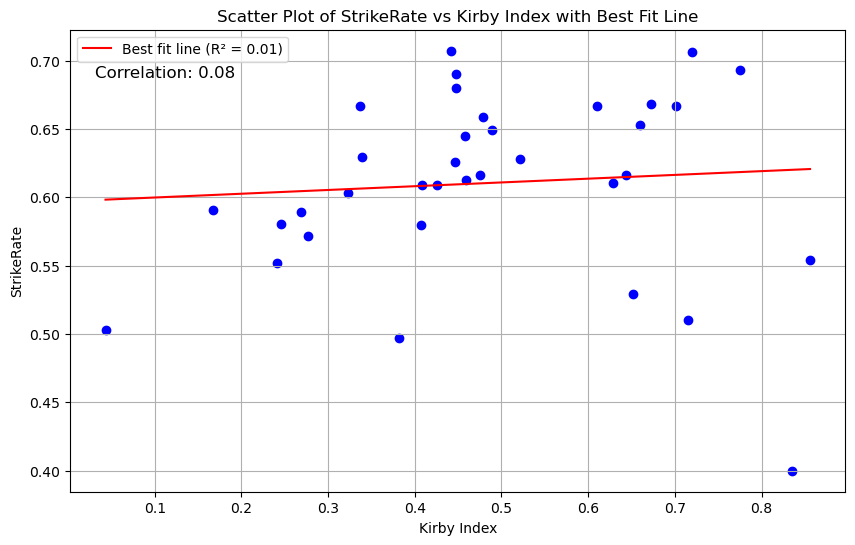

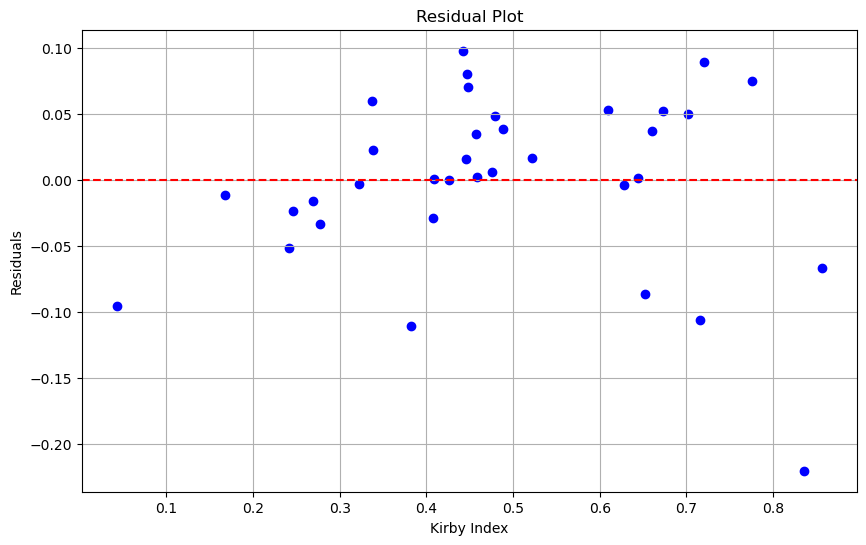

,kirby_index,InZone,Residual
0,0.856000,0.553846,-0.066905
2,0.835429,0.400000,-0.220184
4,0.775143,0.693227,0.074705
5,0.719714,0.706215,0.089220
6,0.715429,0.510549,-0.106328
7,0.701714,0.666667,0.050168
9,0.672571,0.668122,0.052427
10,0.660000,0.652733,0.037384
11,0.652000,0.529032,-0.086096
12,0.643714,0.616438,0.001538


In [47]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['StrikeRate']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of StrikeRate vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('StrikeRate')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
      
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")

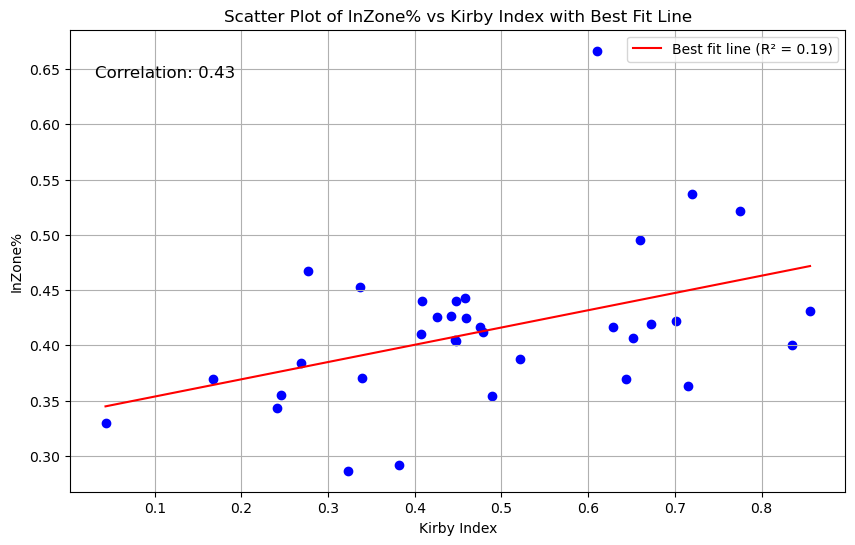

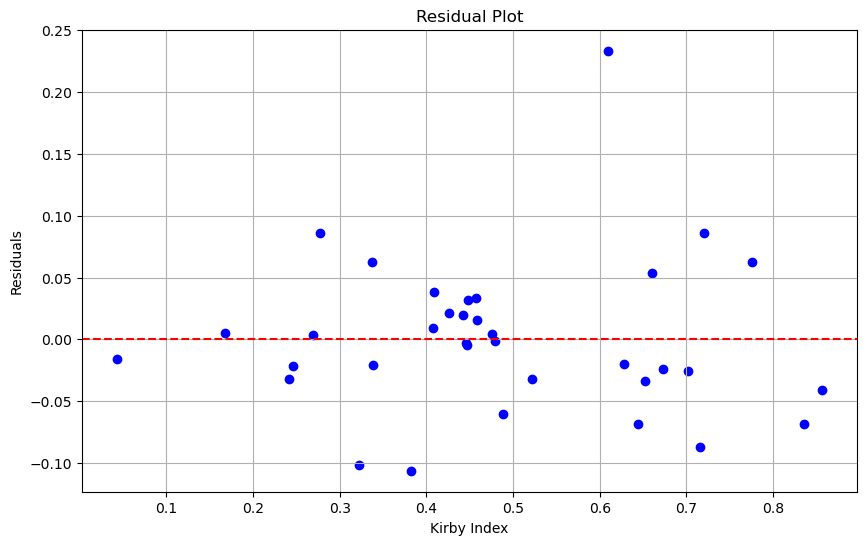

Mean Squared Error (MSE): 0.00


,kirby_index,InZone,Residual
0,0.856000,0.430769,-0.040966
2,0.835429,0.400000,-0.068521
4,0.775143,0.521912,0.062813
5,0.719714,0.536723,0.086286
6,0.715429,0.362869,-0.086898
7,0.701714,0.421687,-0.025937
9,0.672571,0.419214,-0.023856
10,0.660000,0.495177,0.054072
11,0.652000,0.406452,-0.033403
12,0.643714,0.369863,-0.068697


In [48]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Ensure the merged DataFrame has the required columns
if 'InZone' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['InZone']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

    # Calculate residuals
    residuals = y - line

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(residuals ** 2)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of InZone% vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('InZone%')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display MSE
    print(f'Mean Squared Error (MSE): {mse:.2f}')

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)

else:
    print("Required columns 'InZone' and 'kirby_index' are not present in the DataFrame.")


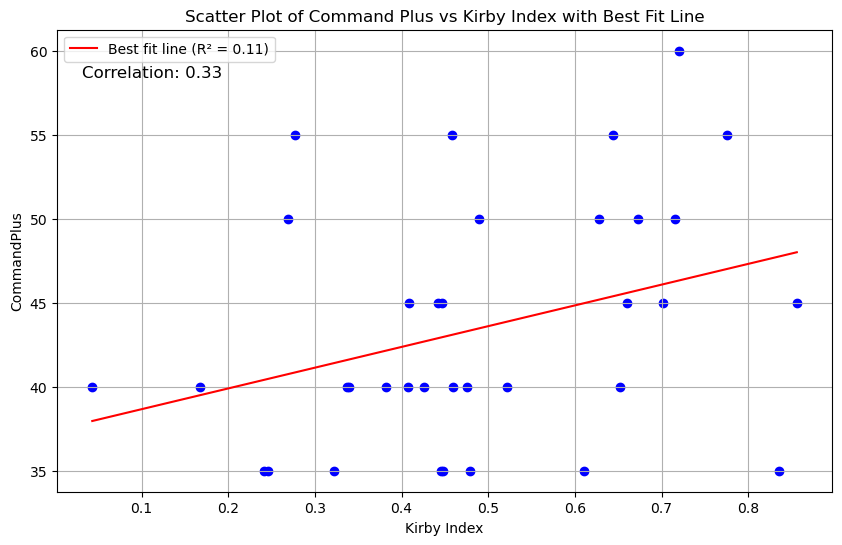

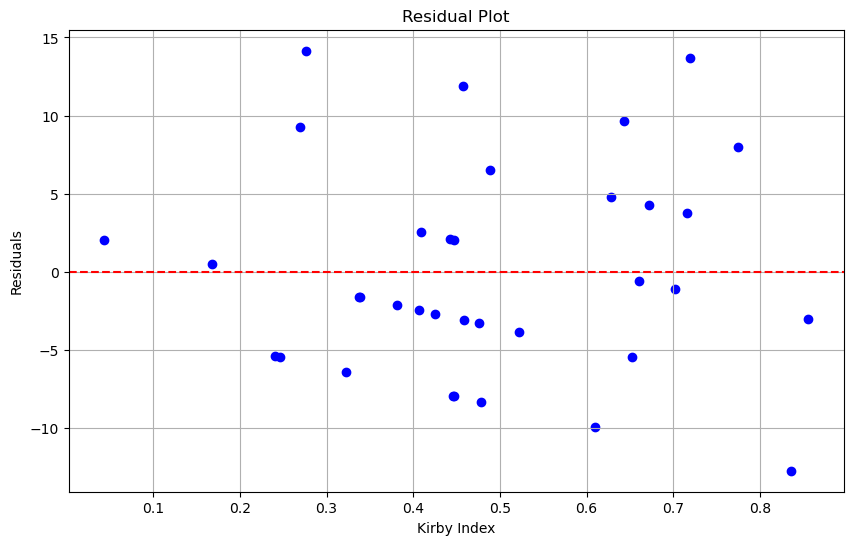

Mean Squared Error (MSE): 44.17


,kirby_index,CommandPlus,Residual
0,0.856000,45,-3.004563
2,0.835429,35,-12.750341
4,0.775143,55,7.994670
5,0.719714,60,13.679656
6,0.715429,50,3.732619
7,0.701714,45,-1.097900
9,0.672571,50,4.262248
10,0.660000,45,-0.582394
11,0.652000,40,-5.483530
12,0.643714,55,9.618864


In [49]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Ensure the merged DataFrame has the required columns
if 'CommandPlus' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['CommandPlus']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

    # Calculate residuals
    residuals = y - line

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(residuals ** 2)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of Command Plus vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('CommandPlus')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display MSE
    print(f'Mean Squared Error (MSE): {mse:.2f}')

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'CommandPlus': y, 'Residual': residuals})
    display(residuals_df)

else:
    print("Required columns 'InZone' and 'kirby_index' are not present in the DataFrame.")


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a m

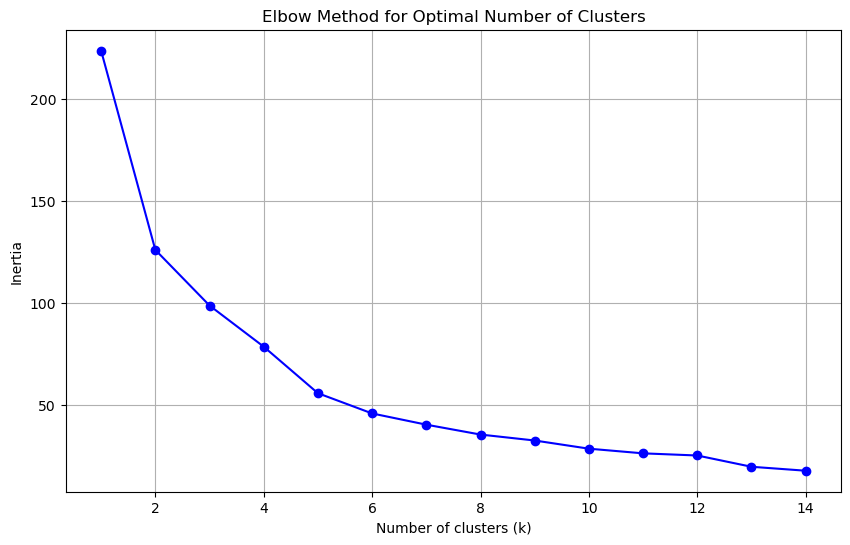

In [50]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Filter for player fastballs
OAK_sl_player_HRA_VRA_CL = OAK_sl_filtered[OAK_sl_filtered['NamePlayer'] == 'Mitch Myers']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_sl_player_HRA_VRA_CL = OAK_sl_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_sl_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering for a range of cluster numbers and calculate inertia
inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow method result
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



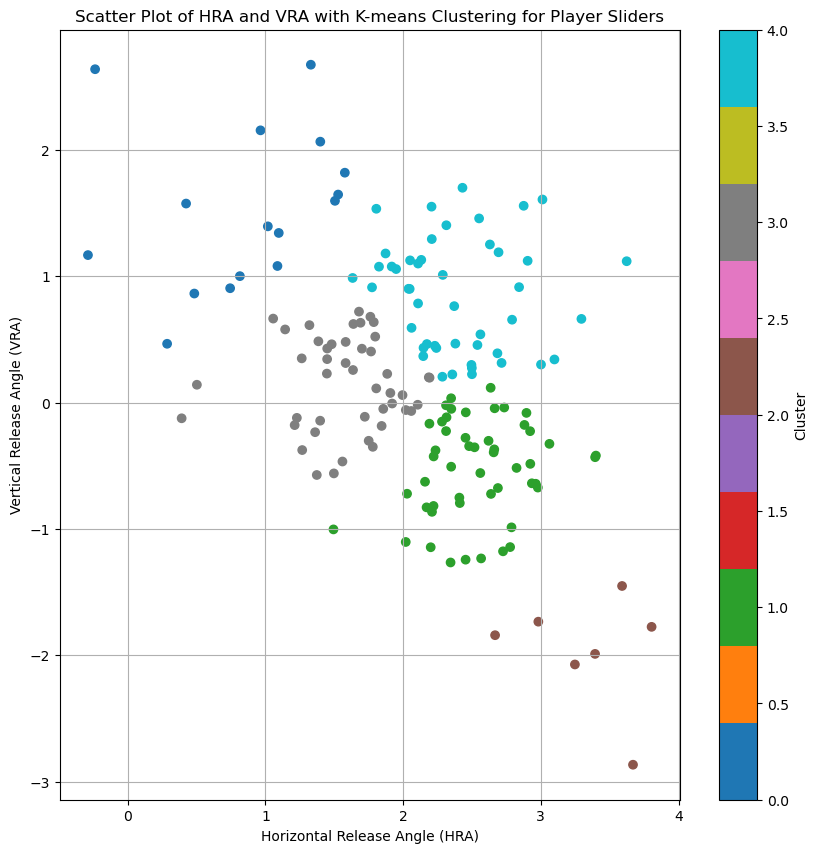

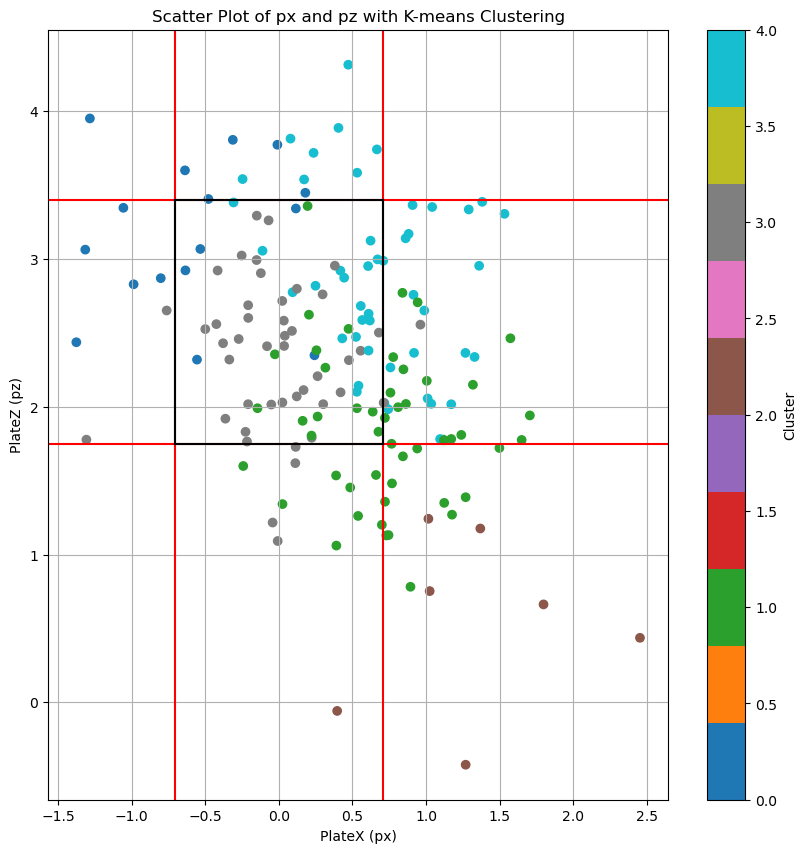

In [51]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=4).fit(X)
OAK_sl_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(OAK_sl_player_HRA_VRA_CL['HRA'], OAK_sl_player_HRA_VRA_CL['VRA'], c=OAK_sl_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
plt.title('Scatter Plot of HRA and VRA with K-means Clustering for Player Sliders')
plt.xlabel('Horizontal Release Angle (HRA)')
plt.ylabel('Vertical Release Angle (VRA)')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(OAK_sl_player_HRA_VRA_CL['px'], OAK_sl_player_HRA_VRA_CL['pz'], c=OAK_sl_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
plt.title('Scatter Plot of px and pz with K-means Clustering')
plt.xlabel('PlateX (px)')
plt.ylabel('PlateZ (pz)')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.axvline(x=0.7083, color='r', linestyle='-')
plt.axvline(x=-0.7083, color='r', linestyle='-')
plt.axhline(y=1.75, color='r', linestyle='-')
plt.axhline(y=3.4, color='r', linestyle='-')

# Add the box
plt.plot([-0.7083, 0.7083], [1.75, 1.75], color='black')
plt.plot([-0.7083, 0.7083], [3.4, 3.4], color='black')
plt.plot([-0.7083, -0.7083], [1.75, 3.4], color='black')
plt.plot([0.7083, 0.7083], [1.75, 3.4], color='black')

plt.show()

In [67]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn.cluster import KMeans
import pandas as pd
import webbrowser


# Filter the DataFrame
OAK_sl_player_HRA_VRA_CL = OAK_sl_filtered[OAK_sl_filtered['NamePlayer'] == 'Hogan Harris']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_sl_player_HRA_VRA_CL = OAK_sl_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_sl_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=10, random_state=4).fit(X)
OAK_sl_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Create the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Graph(id='scatter-hra-vra'),
    dcc.Graph(id='scatter-px-pz'),
    dcc.Location(id='url', refresh=True),
    html.Div(id='redirect-url', style={'display': 'none'})
])

# Callback to update the scatter plot for HRA and VRA
@app.callback(
    Output('scatter-hra-vra', 'figure'),
    Input('scatter-hra-vra', 'clickData')
)
def update_hra_vra(clickData):
    fig1 = px.scatter(OAK_sl_player_HRA_VRA_CL, x='HRA', y='VRA', color='cluster',
                      title='Catcher View Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs',
                      labels={'HRA': 'Horizontal Release Angle (HRA)', 'VRA': 'Vertical Release Angle (VRA)'},
                      hover_data=['URL'])
    fig1.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig1.update_traces(marker=dict(size=10))
    
    return fig1

# Callback to update the scatter plot for px and pz
@app.callback(
    Output('scatter-px-pz', 'figure'),
    Input('scatter-px-pz', 'clickData')
)
def update_px_pz(clickData):
    fig2 = px.scatter(OAK_sl_player_HRA_VRA_CL, x='px', y='pz', color='cluster',
                      title='Catcher View Scatter Plot of px and pz with K-means Clustering',
                      labels={'px': 'PlateX (px)', 'pz': 'PlateZ (pz)'},
                      hover_data=['URL'])
    fig2.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig2.update_traces(marker=dict(size=10))
    
    fig2.add_shape(type='line', x0=0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=-0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=1.75, y1=1.75, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=3.4, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='rect', x0=-0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Black'))
    
    return fig2

# Callback to handle URL redirection
@app.callback(
    Output('redirect-url', 'children'),
    [Input('scatter-hra-vra', 'clickData'),
     Input('scatter-px-pz', 'clickData')]
)
def redirect_url(clickDataHraVra, clickDataPxPz):
    if clickDataHraVra is not None:
        point_index = clickDataHraVra['points'][0]['pointIndex']
        url = OAK_sl_player_HRA_VRA_CL.iloc[point_index]['URL']
        return dcc.Location(href=url, id='url')
    elif clickDataPxPz is not None:
        point_index = clickDataPxPz['points'][0]['pointIndex']
        url = OAK_sl_player_HRA_VRA_CL.iloc[point_index]['URL']
        return dcc.Location(href=url, id='url')
    return ""

# Open a web browser tab with the app URL
def open_browser():
    webbrowser.open_new_tab("http://127.0.0.1:7052/")

# Run the app
if __name__ == '__main__':
    open_browser()
    app.run_server(debug=True, port=7052)


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [53]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Set the environment variable to avoid the memory leak warning
os.environ['OMP_NUM_THREADS'] = '2'

# Define the maximum number of clusters
max_clusters = 10

# Function to find the optimal number of clusters with silhouette score calculation
def find_optimal_clusters_with_silhouette(data, max_clusters):
    inertia = []
    silhouette_scores = []
    K_range = range(3, max_clusters + 1)  # Silhouette score is undefined for k=1
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    
    return inertia, silhouette_scores

# Store the results
results = []

# Iterate over each player
players = OAK_sl_filtered['NamePlayer'].unique()
for player in players:
    # Filter for player's fastballs
    player_data = OAK_sl_filtered[OAK_sl_filtered['NamePlayer'] == player]
    
    # Ensure there are no missing values in 'HRA' and 'VRA' columns
    player_data = player_data.dropna(subset=['HRA', 'VRA'])
    
    # Prepare the data for clustering
    X = player_data[['HRA', 'VRA']]
    
    if not X.empty:
        # Find the optimal number of clusters and calculate silhouette scores
        inertia, silhouette_scores = find_optimal_clusters_with_silhouette(X, max_clusters)
        
        # Find the optimal number of clusters with the highest silhouette score
        optimal_clusters = range(3, max_clusters + 1)[np.argmax(silhouette_scores)]
        
        # Append the result
        results.append({'NamePlayer': player, 'Optimal Clusters': optimal_clusters, 'Inertia': inertia[np.argmax(silhouette_scores)], 'Silhouette Score': max(silhouette_scores)})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print the results for debugging


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a m

In [54]:
print(results_df)

           NamePlayer  Optimal Clusters     Inertia  Silhouette Score
0      Ross Stripling                10  100.198796          0.395330
1        Dany Jiménez                 3  381.718887          0.390129
2           Alex Wood                 3  254.097994          0.387216
3        Austin Adams                 9  315.533971          0.345384
4        Mason Miller                 6  144.813592          0.378218
5        Hogan Harris                10   46.568731          0.397920
6          Joey Estes                 3  154.452394          0.365645
7         Kyle Muller                 3  164.708118          0.417468
8       Michel Otañez                 3  253.323164          0.395929
9         Luis Medina                 9  103.586777          0.397000
10    Jack O'Loughlin                 3  487.958425          0.387609
11       Aaron Brooks                 3  247.357277          0.382909
12          Joe Boyle                 8  315.403351          0.377943
13      Austin Brigg

In [57]:
results_df.rename(columns={'Player': 'NamePlayer'}, inplace=True)

# Merge results_df onto OAK_select
OAK_full_slider_w_optimal_clusters = pd.merge(OAK_full_slider_command_unique, results_df, how='left', on='NamePlayer')

columns_to_drop = ['VRA', 'HRA', 'ReleaseX', 'ReleaseZ', 'PlayerID', 'Inertia']
OAK_full_sslider_w_optimal_clusters = OAK_full_slider_w_optimal_clusters.drop(columns=columns_to_drop)

display(OAK_full_slider_w_optimal_clusters)


,NamePlayer,PitcherId,VRA,HRA,ReleaseX,ReleaseZ,VRA_percentile,HRA_percentile,release_pos_z_percentile,release_pos_x_percentile,kirby_index,PlayerID,StrikeRate,CalledStrikeRate,CommandPlus,InZone,Optimal Clusters,Inertia,Silhouette Score
0,Joey Estes,683155,0.882522,0.718880,0.129545,0.092734,0.828571,0.885714,0.828571,0.914286,0.856000,683155,0.553846,0.200000,45,0.430769,3,154.452394,0.365645
1,Ross Stripling,548389,0.980691,0.592861,0.142107,0.082325,0.714286,0.971429,0.971429,0.771429,0.835429,548389,0.400000,0.000000,35,0.400000,10,100.198796,0.395330
2,Osvaldo Bido,674370,0.846937,0.888882,0.144333,0.089751,0.885714,0.514286,0.942857,0.742857,0.775143,674370,0.693227,0.119522,55,0.521912,10,43.475112,0.366735
3,Mitch Myers,688490,0.910683,0.730345,0.195653,0.104155,0.800000,0.857143,0.542857,0.428571,0.719714,688490,0.706215,0.090395,60,0.536723,10,26.074473,0.373597
4,Alex Wood,622072,0.800524,1.012007,0.095036,0.098618,0.971429,0.257143,0.600000,0.971429,0.715429,622072,0.510549,0.232068,50,0.362869,3,254.097994,0.387216
5,Aaron Brooks,605156,0.857895,0.895637,0.157542,0.094827,0.857143,0.457143,0.742857,0.657143,0.701714,605156,0.666667,0.172691,45,0.421687,3,247.357277,0.382909
6,Mason Miller,695243,0.956870,0.962914,0.139084,0.093168,0.771429,0.342857,0.800000,0.857143,0.672571,695243,0.668122,0.222707,50,0.419214,6,144.813592,0.378218
7,Gunnar Hoglund,680684,1.000765,0.848771,0.199606,0.092384,0.657143,0.657143,0.885714,0.400000,0.660000,680684,0.652733,0.147910,45,0.495177,7,92.625389,0.361806
8,Luis Carrasco,682918,0.826665,0.891628,0.204596,0.118397,0.942857,0.485714,0.428571,0.371429,0.652000,682918,0.529032,0.174194,40,0.406452,9,53.684342,0.399144
9,Jack Cushing,681007,0.991422,0.800705,0.247515,0.097489,0.685714,0.800000,0.657143,0.200000,0.643714,681007,0.616438,0.116438,55,0.369863,7,41.209197,0.365060
